# **Import Libraries**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os

# **Data Loading**

In [ ]:
# Path to the zip file
#zip_path = '/content/drive/MyDrive/skeleton_bin_data.zip'
# Destination folder
#output_dir = '/content/drive/MyDrive/skeleton_bin_data'

# Create output directory if it doesn't exist
#os.makedirs(output_dir, exist_ok=True)

# Unzipping the file
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(output_dir)

#print(f"Data unzipped to {output_dir}")

Data unzipped to /content/drive/MyDrive/skeleton_bin_data


## *Helper Function to collect all image-skeleton pairs*

In [ ]:
import os
from pathlib import Path
import shutil

# Path to your dataset and target folder
dataset_root = Path("/content/drive/MyDrive/skeleton_bin_data/Données")
target_folder = Path("/content/drive/MyDrive/skeleton_bin_data/UnifiedData")
images_target = target_folder / "image"
skeletons_target = target_folder / "skeleton"

# Ensure target directories exist
images_target.mkdir(parents=True, exist_ok=True)
skeletons_target.mkdir(parents=True, exist_ok=True)

# Function to collect and save all data
def consolidate_data(base_path, target_image_dir, target_skeleton_dir):
    file_count = 0

    # Traverse through all subdirectories in the dataset
    for folder in base_path.iterdir():
        if folder.is_dir():
            images_folder = folder / "ori"
            skeleton_folder = folder / "skeleton"

            # Ensure the directories exist
            if images_folder.exists() and skeleton_folder.exists():
                image_files = sorted(images_folder.glob("*"))  # Sorted to ensure alignment
                skeleton_files = sorted(skeleton_folder.glob("*"))

                # Ensure counts match
                if len(image_files) != len(skeleton_files):
                    print(f"Warning: Mismatch in counts for {folder}")

                # Copy files to the target folders
                for img_path, skl_path in zip(image_files, skeleton_files):
                    file_count += 1
                    # Generate new file names to avoid overwriting
                    img_target_path = target_image_dir / f"{file_count:06d}_{img_path.name}"
                    skl_target_path = target_skeleton_dir / f"{file_count:06d}_{skl_path.name}"

                    # Copy files
                    shutil.copy(img_path, img_target_path)
                    shutil.copy(skl_path, skl_target_path)
            else:
                print(f"Skipping {folder}, 'ori' or 'skeleton' folder missing.")

    return file_count

In [ ]:
# Consolidate data
total_files = consolidate_data(dataset_root, images_target, skeletons_target)
print(f"Successfully consolidated {total_files} image-skeleton pairs into '{target_folder}'.")

Successfully consolidated 12840 image-skeleton pairs into '/content/drive/MyDrive/skeleton_bin_data/UnifiedData'.


In [5]:
# Path to your dataset
dataset_path = Path("/content/drive/MyDrive/skeleton_bin_data/UnifiedData")
images_path = dataset_path / "image"
skeleton_path = dataset_path / "skeleton"

## *Helper Function to Walk Through Directories*

In [6]:
# Function to walk through directories
def walk_through_dir(base_path):
    for dirpath, dirnames, filenames in os.walk(base_path):
        print(f'Found {len(filenames)} images in {dirpath}')
        break

# Walk through images and masks directories
walk_through_dir(images_path)
walk_through_dir(skeleton_path)

Found 12840 images in /content/drive/MyDrive/skeleton_bin_data/UnifiedData/image
Found 12840 images in /content/drive/MyDrive/skeleton_bin_data/UnifiedData/skeleton


## *Helper Class for Data Loading*

In [7]:
import cv2
import numpy as np
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torchvision.transforms import Resize

class PoreSegmentationDataset(Dataset):
    def __init__(self, image_paths, skeleton_path, transform=None, target_size=(256, 256), dilation_kernel_size=3):
        self.image_paths = image_paths
        self.skeleton_path = skeleton_path
        self.transform = transform
        self.target_size = target_size
        self.kernel = np.ones((dilation_kernel_size, dilation_kernel_size), np.uint8)  # Kernel for dilation
        self.resize = Resize(target_size)  # Resizing transformation

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load image and skeleton
            image = Image.open(self.image_paths[idx]).convert("L")  # Grayscale
            skeleton = Image.open(self.skeleton_path[idx]).convert("L")  # Grayscale
        except Exception as e:
            raise RuntimeError(f"Error loading image or skeleton: {e}")

        # Convert skeleton to a NumPy array for processing
        skeleton = np.array(skeleton)

        # Ensure binary mask (thresholding)
        _, binary_skeleton = cv2.threshold(skeleton, 127, 255, cv2.THRESH_BINARY)

        # Apply dilation
        dilated_skeleton = cv2.dilate(binary_skeleton, self.kernel, iterations=1)

        # Convert back to PIL Image for resizing
        dilated_skeleton = Image.fromarray(dilated_skeleton)

        # Resize image and skeleton
        image = self.resize(image)
        dilated_skeleton = self.resize(dilated_skeleton)

        # Convert to tensors and normalize
        image = ToTensor()(image)  # Convert to Tensor and normalize to [0, 1]
        skeleton_tensor = ToTensor()(dilated_skeleton).float()  # Convert to Tensor and normalize to [0, 1]

        # Ensure binary masks after dilation
        skeleton_tensor = (skeleton_tensor > 0.5).float()

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            skeleton_tensor = self.transform(skeleton_tensor)

        return image, skeleton_tensor

# **Load and Transform Data**

In [8]:
import re

In [9]:
# Define a function to extract the numeric part of a filename
def extract_number(path):
    match = re.search(r'(\d+)', path.name)
    return int(match.group(1)) if match else float('inf')  # Handle cases with no number

# Sort paths numerically
image_paths = sorted(images_path.glob("*.png"), key=extract_number)
skeleton_paths = sorted(skeleton_path.glob("*.png"), key=extract_number)

In [10]:
import random

# Set a random seed for reproducibility
random.seed(42)

# Define the sample size
sample_size = 1000  # Adjust this to the desired number of samples

# Sample a subset of the data
sampled_indices = random.sample(range(len(image_paths)), sample_size)
sampled_image_paths = [image_paths[i] for i in sampled_indices]
sampled_skeleton_paths = [skeleton_paths[i] for i in sampled_indices]

# Split the sampled data into train, validation, and test sets
train_image_paths, test_image_paths, train_skeleton_paths, test_skeleton_paths = train_test_split(
    sampled_image_paths, sampled_skeleton_paths, test_size=0.2
)
train_image_paths, val_image_paths, train_skeleton_paths, val_skeleton_paths = train_test_split(
    train_image_paths, train_skeleton_paths, test_size=0.2
)

# Create datasets
train_dataset = PoreSegmentationDataset(train_image_paths, train_skeleton_paths)
val_dataset = PoreSegmentationDataset(val_image_paths, val_skeleton_paths)
test_dataset = PoreSegmentationDataset(test_image_paths, test_skeleton_paths)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=30, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False)

In [11]:
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Train set size: 640
Validation set size: 160
Test set size: 200


In [12]:
for images, skeletons in train_loader:
    print(f"Batch image shape: {images.shape}")
    print(f"Batch skeleton shape: {skeletons.shape}")
    break  # Check the first batch

Batch image shape: torch.Size([30, 1, 256, 256])
Batch skeleton shape: torch.Size([30, 1, 256, 256])


## *Visualizing a Random Sample*

In [13]:
import torchvision.transforms as T
import random

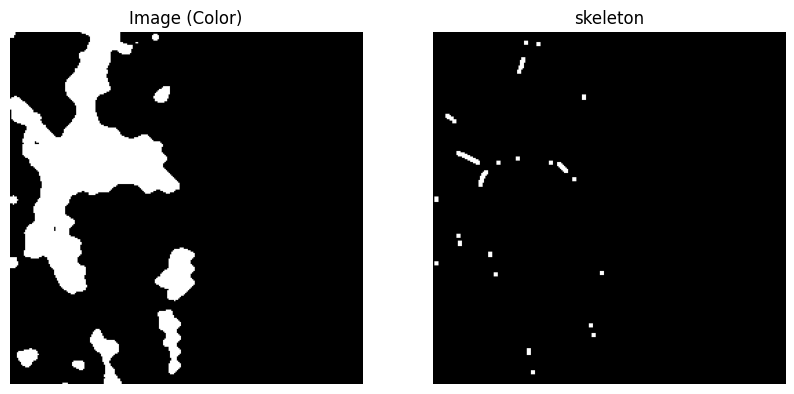

In [14]:
# Function to display a random image and its mask
def display_random_image_with_skeleton(dataset):
    # Randomly select an index
    idx = random.randint(0, len(dataset) - 1)

    # Get the image and skeleton
    image, skeleton = dataset[idx]

    # If tensors, convert to PIL for visualization
    if isinstance(image, torch.Tensor):
        image = T.ToPILImage()(image)
    if isinstance(skeleton, torch.Tensor):
        skeleton = T.ToPILImage()(skeleton)

    # Display the image and mask
    plt.figure(figsize=(10, 5))

    # Display image in color
    plt.subplot(1, 2, 1)
    plt.imshow(image,cmap="gray")  # Displays image in GrayScale
    plt.title("Image (Color)")
    plt.axis("off")

    # Display skeleton
    plt.subplot(1, 2, 2)
    plt.imshow(skeleton, cmap="gray")
    plt.title("skeleton")
    plt.axis("off")

    plt.show()

# Display random image with skeleton from training dataset
display_random_image_with_skeleton(train_dataset)

# **Model (UNet Architecture)**

In [15]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        self.upconv1 = self.upconv_block(512, 256)
        self.upconv2 = self.upconv_block(256, 128)
        self.upconv3 = self.upconv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

        self.upsample_to_input = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Added Batch Normalization
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Added Batch Normalization
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),  # Added Batch Normalization
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)

        dec1 = self.upconv1(enc4)
        dec2 = self.upconv2(dec1 + enc3)
        dec3 = self.upconv3(dec2 + enc2)

        final = self.final(dec3 + enc1)

        if final.shape[-2:] != x.shape[-2:]:
            final = self.upsample_to_input(final)

        return final

# **Loss Functions**

In [16]:
def dice_loss(pred, target, smooth=1e-6, foreground_weight=0.95, background_weight=0.05):
    """
    Compute the weighted Dice Loss for 2D segmentation tasks.

    Args:
        pred (torch.Tensor): Predicted logits of shape (batch_size, 1, H, W).
        target (torch.Tensor): Ground truth binary masks of shape (batch_size, 1, H, W).
        smooth (float): Smoothing factor to avoid division by zero.
        foreground_weight (float): Weight for the foreground class.
        background_weight (float): Weight for the background class.

    Returns:
        torch.Tensor: The weighted Dice Loss.
    """
    # Apply sigmoid activation to the predictions to get probabilities
    pred = torch.sigmoid(pred)

    # Ensure target shape matches prediction shape
    if target.shape != pred.shape:
        target = torch.nn.functional.interpolate(target, size=pred.shape[2:], mode="bilinear", align_corners=False)

    # Flatten for Dice loss computation
    pred = pred.view(pred.size(0), -1)  # Shape: (batch_size, H*W)
    target = target.view(target.size(0), -1)  # Shape: (batch_size, H*W)

    # Calculate the intersection, sum of predictions, and sum of targets
    intersection = (pred * target).sum(dim=1)  # Shape: (batch_size,)
    pred_sum = pred.sum(dim=1)  # Shape: (batch_size,)
    target_sum = target.sum(dim=1)  # Shape: (batch_size,)

    # Calculate Dice coefficient
    dice = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)

    # Apply weights for foreground and background
    target_mean = target.mean(dim=1)  # Average presence of foreground pixels
    weighted_dice = (
        foreground_weight * dice * target_mean +
        background_weight * dice * (1 - target_mean)
    )

    # Return the average Dice Loss across the batch
    return 1 - weighted_dice.mean()

In [24]:
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = torch.nn.functional.interpolate(pred, size=(256, 256), mode='bilinear', align_corners=True)
    pred = pred.view(pred.size(0), -1)
    target = target.view(target.size(0), -1)

    intersection = (pred * target).sum(dim=1)
    pred_sum = pred.sum(dim=1)
    target_sum = target.sum(dim=1)

    dice = (2. * intersection + smooth) / (pred_sum + target_sum + smooth)

    return 1 - dice.mean()

In [17]:
def iou_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()  # Thresholding
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

# **Model Training**

In [18]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(1, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

## *Save the Model & Training History*

In [ ]:
history = {
    "train_loss": [],
    "val_loss": [],
    "iou_score": []
}

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, skeleton in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, skeleton = images.to(device), skeleton.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = dice_loss(outputs, skeleton)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss}")

    model.eval()
    val_loss = 0.0
    iou = 0.0
    with torch.no_grad():
        for images, skeleton in val_loader:
            images, skeleton = images.to(device), skeleton.to(device)
            outputs = model(images)

            val_loss += dice_loss(outputs, skeleton).item()
            iou += iou_score(outputs, skeleton).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_iou = iou / len(val_loader)
    history["val_loss"].append(avg_val_loss)
    history["iou_score"].append(avg_iou)
    print(f"Validation Loss: {avg_val_loss}, IoU Score: {avg_iou}")

Epoch 1/100:   0%|          | 0/22 [00:00<?, ?it/s]

In [51]:
# Define the model save path
model_save_dir = "/content/drive/MyDrive/Skeleton_Trained_Model_2D"
os.makedirs(model_save_dir, exist_ok=True)

# Save the model
def save_model(model, model_save_dir):
    model_path = os.path.join(model_save_dir, "model_v2.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")

# Call the function to save the model
save_model(model, model_save_dir)

Model saved at /content/drive/MyDrive/Skeleton_Trained_Model_2D/model_v2.pth


In [52]:
import pickle

# Save the training history (as a pickle file)
history_path = os.path.join(model_save_dir, "history_v2.pkl")
with open(history_path, 'wb') as history_file:
    pickle.dump(history, history_file)
print(f"History saved at {history_path}")

History saved at /content/drive/MyDrive/Skeleton_Trained_Model_2D/history_v2.pkl


## *Load the Model & Training History*

In [ ]:
# Define the model instance
model = UNet(in_channels=1, out_channels=1)  # Example for input RGB images and binary segmentation output
model.load_state_dict(torch.load(model_save_dir+"/model.pth"))

# If using GPU, move the model to the correct device (e.g., CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Load the history
with open(os.path.join(model_save_dir, "history.pkl"), 'rb') as history_file:
    history = pickle.load(history_file)

print("Model and history loaded successfully!")

## *Visualize the Training History*

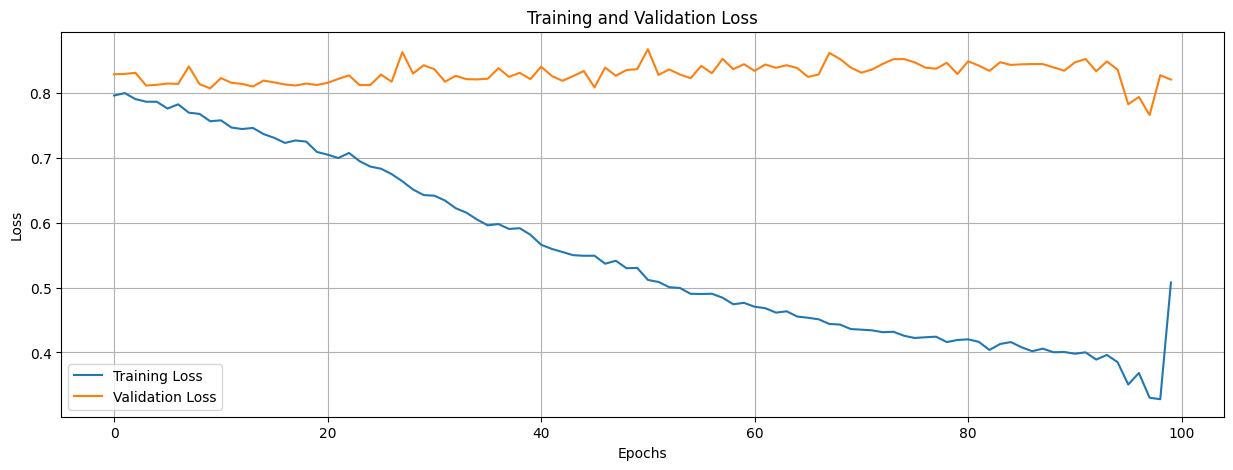

In [53]:
# Plot training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

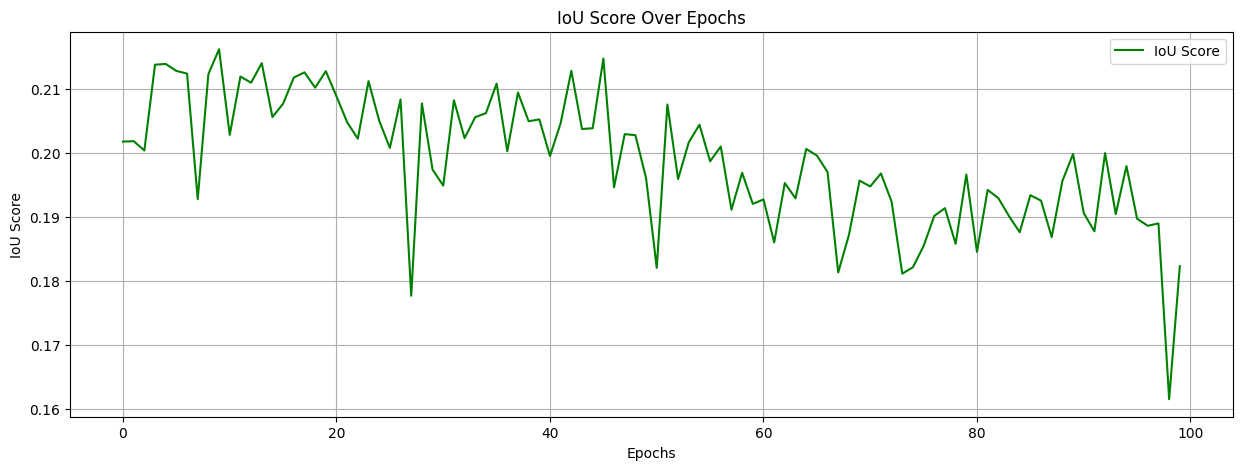

In [54]:
# Plot IoU score
plt.figure(figsize=(15, 5))
plt.plot(history["iou_score"], label="IoU Score", color="green")
plt.xlabel("Epochs")
plt.ylabel("IoU Score")
plt.title("IoU Score Over Epochs")
plt.legend()
plt.grid()
plt.show()

# **Evaluate the Model**

## *Validation and Testing*

In [55]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

In [56]:
def dice_coefficient(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-8)

def iou(pred, target):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return intersection / (union + 1e-8)

# Evaluate model on test dataset
def evaluate_model(model, dataloader, threshold=0.5):
    model.eval()
    dice_scores, iou_scores, precisions, recalls, f1s = [], [], [], [], []

    with torch.no_grad():
        for images, skeleton in dataloader:
            images, skeleton = images.to(device), skeleton.to(device)
            outputs = model(images)
            preds = (outputs.sigmoid() > threshold).float()

            for pred, skeleton in zip(preds, skeleton):
                dice_scores.append(dice_coefficient(pred.cpu().numpy(), skeleton.cpu().numpy()))
                iou_scores.append(iou(pred.cpu().numpy(), skeleton.cpu().numpy()))
                precisions.append(precision_score(skeleton.cpu().numpy().flatten(), pred.cpu().numpy().flatten()))
                recalls.append(recall_score(skeleton.cpu().numpy().flatten(), pred.cpu().numpy().flatten()))
                f1s.append(f1_score(skeleton.cpu().numpy().flatten(), pred.cpu().numpy().flatten()))

    print(f"Dice Coefficient: {np.mean(dice_scores):.4f}")
    print(f"IoU: {np.mean(iou_scores):.4f}")
    print(f"Precision: {np.mean(precisions):.4f}")
    print(f"Recall: {np.mean(recalls):.4f}")
    print(f"F1 Score: {np.mean(f1s):.4f}")

In [ ]:
evaluate_model(model, test_loader)

## *Error Analysis*

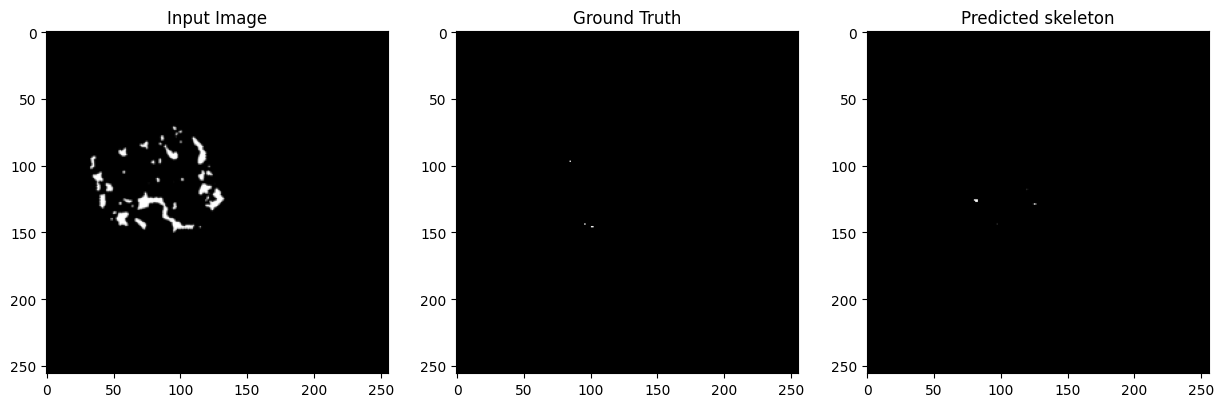

In [58]:
# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for images, skeleton in test_loader:
        # Move images and masks to the device
        images, skeleton = images.to(device), skeleton.to(device)

        # Get the model outputs
        outputs = model(images)
        outputs = torch.sigmoid(outputs).cpu().numpy()  # Apply sigmoid and move to CPU
        outputs = (outputs * 255).astype(np.uint8)  # Scale to [0, 255] for visualization

        images = images.cpu().numpy()
        skeleton = skeleton.cpu().numpy()

        # Visualize the input image, ground truth, and predicted mask
        fig, axes = plt.subplots(1, 3, figsize=(15, 6))

        # Input image (grayscale)
        axes[0].imshow(images[0, 0], cmap='gray')
        axes[0].set_title("Input Image")

        # Ground truth mask (binary, scaled to [0, 255] for visualization)
        axes[1].imshow(skeleton[0, 0], cmap='gray')
        axes[1].set_title("Ground Truth")

        # Predicted mask (scaled to [0, 255])
        axes[2].imshow(outputs[0, 0], cmap='gray')
        axes[2].set_title("Predicted skeleton")

        # Display the visualization
        plt.show()

        break

# **Interpret Results**